In [1]:
import os
import h5py
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
import numpy as np
from iminuit import minuit
from iminuit.cost import LeastSquares

In [2]:
parent = r'C:\Users\ricca\Desktop\MAGISTRALE\QTLab2324\IRdetection\2o raff\Data'

In [3]:
def reader(parent):

    data = {
        "res1" : [],
        "res2" : [],
        "res3" : [],
        "res4" : []
    }

    for folder in os.listdir(parent):
        if folder.startswith("T"):
            T = folder.replace('T_','')
            for file in os.listdir(parent + '/' + folder):
                dic = {
                    'F' : [],
                    'I' : [],
                    'Q' : [],
                    'S21' : []
                }
                with h5py.File(parent + '/' + folder + '/' + file, 'r') as f:
                    dic['F'] = np.array(f['raw_data']['f'][:])
                    dic['I'] = np.array(f['raw_data']['i'][:])
                    dic['Q'] = np.array(f['raw_data']['q'][:])
                    dic['S21'] = 20*np.log(np.sqrt(dic['I']**2 + dic['Q']**2))
                    dic['Phi'] = np.arctan(dic['I']/dic['Q'])
                    if '1' in file:
                        data['res1'].append([T, dic])
                    elif '2' in file:
                        data['res2'].append([T, dic])
                    elif '3' in file:
                        data['res3'].append([T, dic])
                    elif '4' in file:
                        data['res4'].append([T, dic])
    
    return data 

In [4]:
def resonance_model(x,a, Q, Qc,phi0):
    return -a*np.abs(1-Q/Qc*np.exp(1j*phi0)/(1+1j*((2*x*Q))))

def model(x, a0, a1, a2, Q, Qc,phi0):
    params = np.array([a0,a1,a2])
    pol = np.polyval(params, x)
    res = resonance_model(x, a0, Q,Qc,phi0)
    return res*pol

In [5]:
data = reader(parent)

In [6]:
F, T, S21, Phi, I, Q = [], [], [], [],[], []
   
for i,datas in enumerate(data['res2']):
    T.append(int(datas[0]))
    S21.append(datas[1]['S21'])
    F.append(datas[1]['F'])
    Phi.append(datas[1]['Phi'])
    I.append(datas[1]['I'])
    Q.append(datas[1]['Q'])

In [7]:
sorted_indices = sorted(range(len(T)), key=lambda k: T[k])
sorted_T   = [T[i] for i in sorted_indices]
sorted_S21 = [S21[i] for i in sorted_indices]
sorted_Phi = [Phi[i] for i in sorted_indices]
sorted_F   = [F[i] for i in sorted_indices]
sorted_I   = [I[i] for i in sorted_indices]
sorted_Q   = [Q[i] for i in sorted_indices]

Vediamo cosa acccade nel piano IQ

Text(0.5, 0, '$\\nu$')

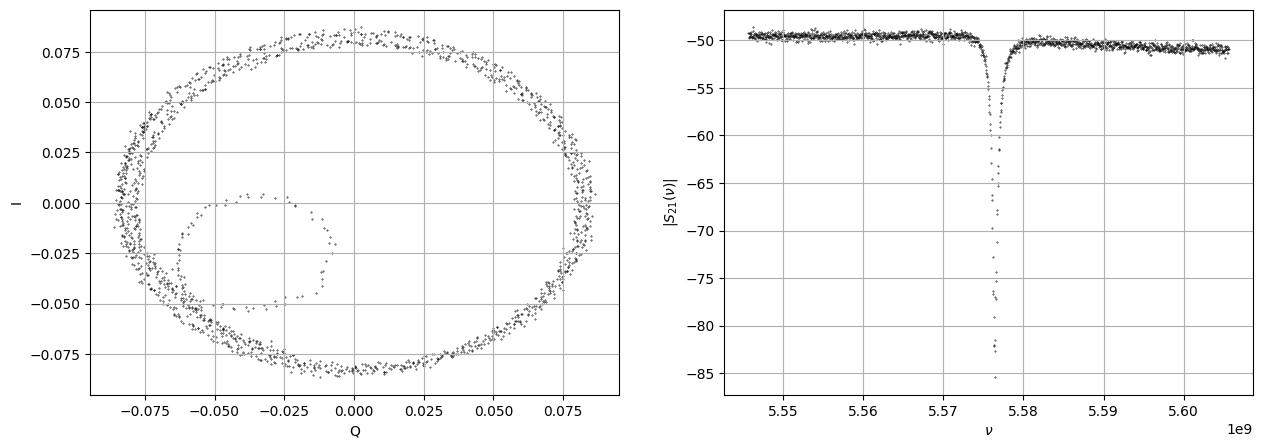

In [8]:
fig, axs  = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(sorted_Q[0],sorted_I[0], marker='.', s=0.5, color='black', alpha=1)
axs[0].grid()
axs[0].set_ylabel('I')
axs[0].set_xlabel('Q')
axs[1].scatter(sorted_F[0],sorted_S21[0], marker='.', s=0.5, color='black', alpha=1)
axs[1].grid()
axs[1].set_ylabel(r'$|S_{21}(\nu)|$')
axs[1].set_xlabel(r'$\nu$')

In [9]:
def Q_stima(x0,w):
    if (((x0 is None) or (w is None)) or w==0):
        print('Q_stima: None detected!')
        return 0
    else:
        return x0/w
    
def FWHM(x,y):
    x = np.array(x)
    y = np.array(np.power(10,(y/20)))
    half = np.max(y) - (np.max(y)-np.abs(y)) / 2.
    minimums = x[np.where(y < half)]
    return (max(minimums) - min(minimums))

def new_model(x,a,b,c,Q,Qc,phi):
    return b*x+c*x**2+a*(1+(1-(2*Q*np.cos(phi))/(Qc)-(4*Q**2*np.sin(phi)*x)/(Qc))/(1+4*Q**2*x**2))

def resonance(x, Q, Qc,phi0):
    return np.abs(1-Q/Qc*np.exp(1j*phi0)/(1+1j*(2*x*Q)))

def model2(x, a0, a1, a2, Q, Qc, phi0):
    params = np.array([a0,a1,a2])
    pol = np.polyval(params, x)
    res = resonance(x,Q,Qc,phi0)
    return res*pol

In [10]:
c_test  = -45
b_test  = 150
a_test  = -300
Q_test  = 7000
Qc_test  = 9000
phi_test = 3
p = [a_test,b_test,c_test,Q_test,Qc_test,phi_test]

In [11]:
F = sorted_F[0]
S21 = sorted_S21[0]
F = (F-F[np.argmin(S21)])/(F[np.argmin(S21)]) 
lsq = LeastSquares(F,S21,1.44*np.ones_like(S21),model2)
m = minuit.Minuit(lsq,*p)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 89.63 (χ²/ndof = 0.1)      │              Nfcn = 156              │
│ EDM = 3.39e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a0   │   -22e3   │    4e3    │            │            │         │         │       │
│ 1 │ a1   │   -147    │    12     │            │            │         │         │       │
│ 2 │ a2   │  -49.78   │   0.06    │            │            │         │         │       │
│ 3 │ Q    │  8.58e3   │  0.21e3   │            │            │         │         │       │
│ 4 │ Qc   │  13.08e3  │  0.23e3   │            │            │         │         │       │
│ 5 │ phi0 │   3.229   │   0.014   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬───────────────────────────────────────────────────────────────────┐
│      │         a0         a1         a2          Q         Qc       phi0 │
├──────┼───────────────────────────────────────────────────────────────────┤
│   a0 │   1.92e+07     4.06e3   -203.581     0.16e6     0.31e6   -1.24968 │
│   a1 │     4.06e3        138     -0.023    -0.01e3    -0.03e3   34.69e-3 │
│   a2 │   -203.581     -0.023    0.00359     -3.278     -5.964    0.01e-3 │
│    Q │     0.16e6    -0.01e3     -3.278   4.44e+04     0.04e6 -229.35e-3 │
│   Qc │     0.31e6    -0.03e3     -5.964     0.04e6   5.06e+04 -369.73e-3 │
│ phi0 │   -1.24968   34.69e-3    0.01e-3 -229.35e-3 -369.73e-3   0.000183 │
└──────┴───────────────────────────────────────────────────────────────────┘

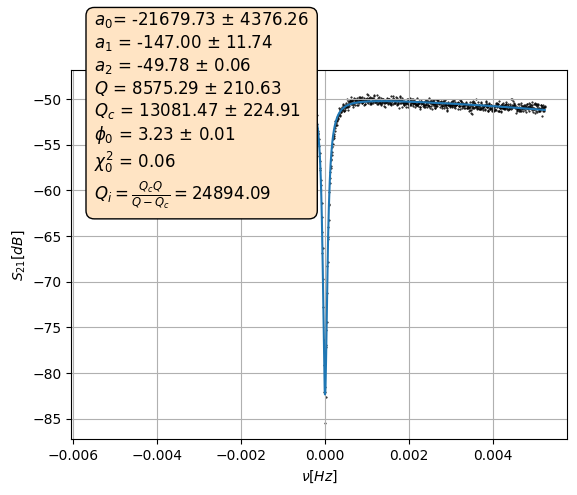

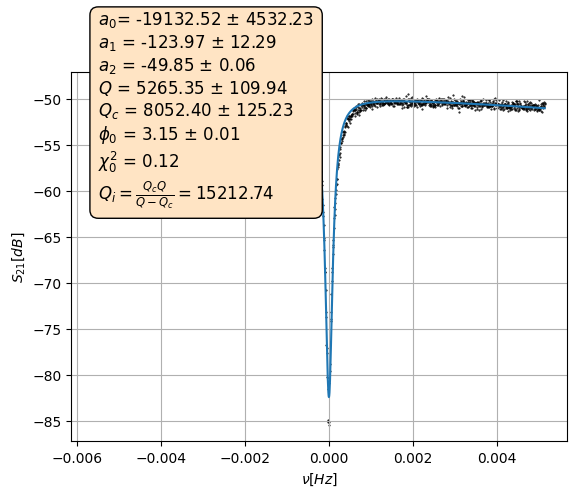

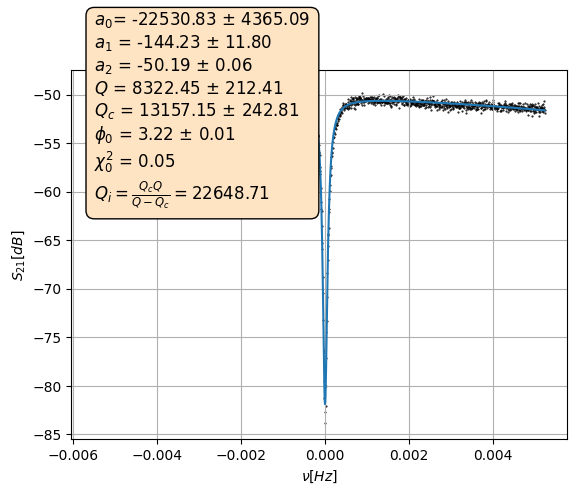

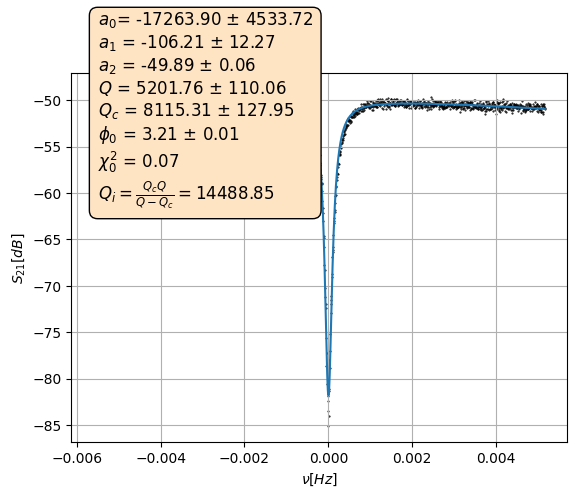

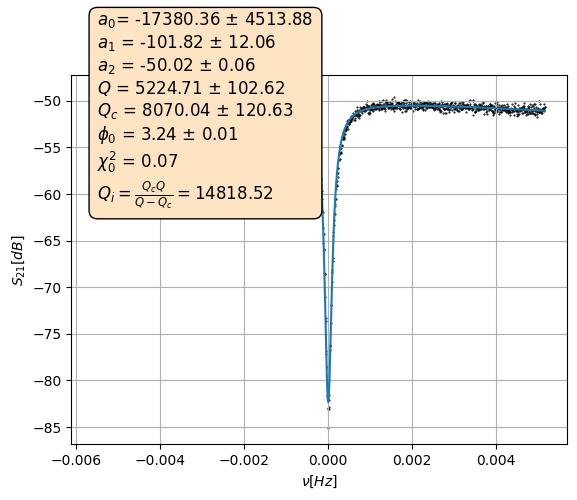

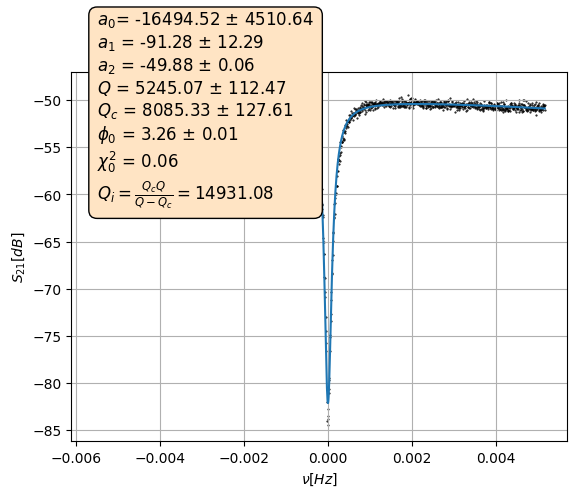

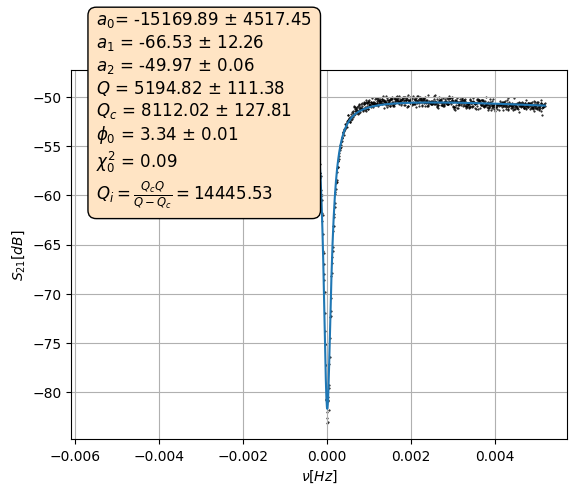

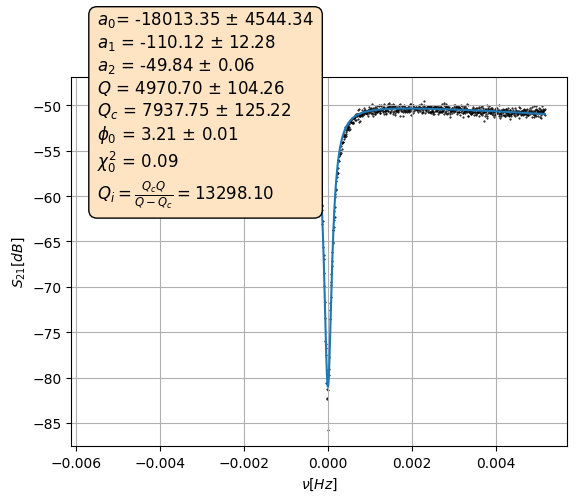

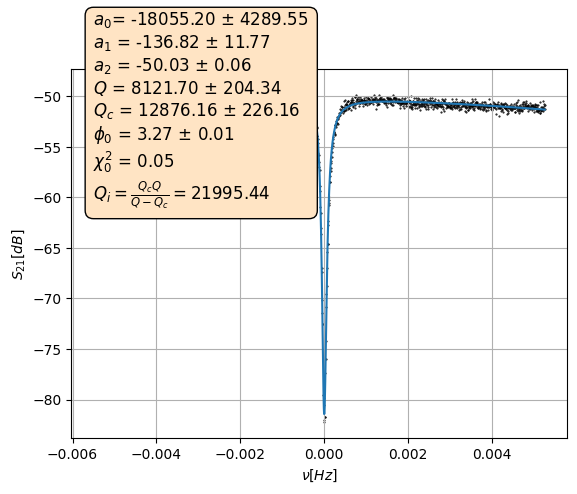

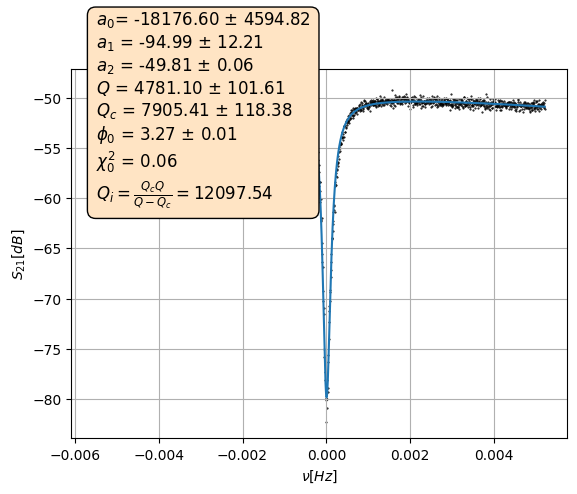

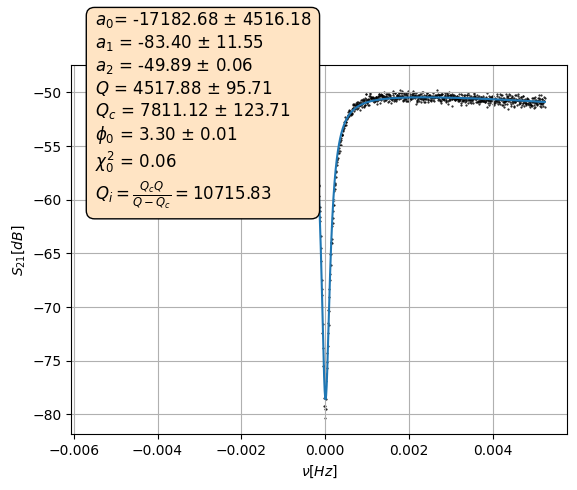

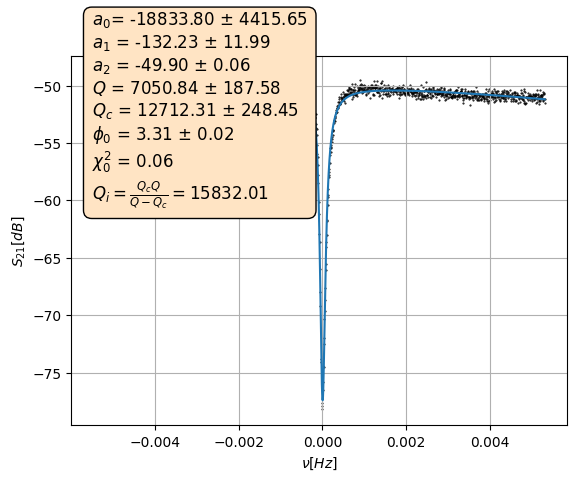

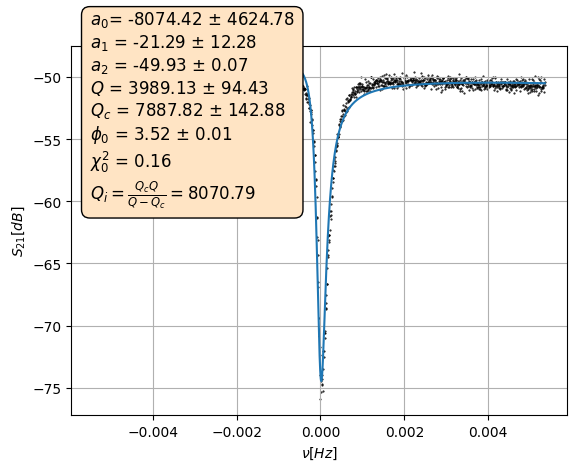

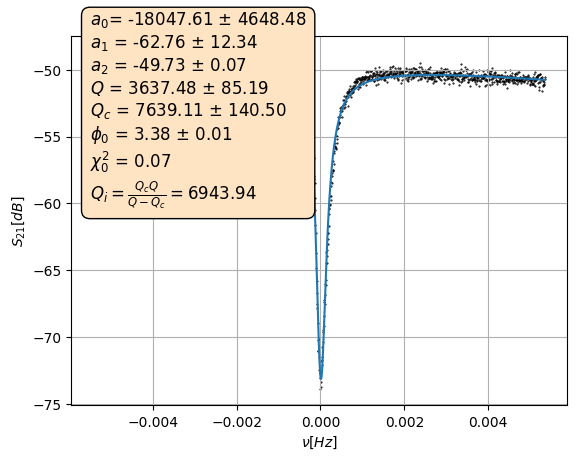

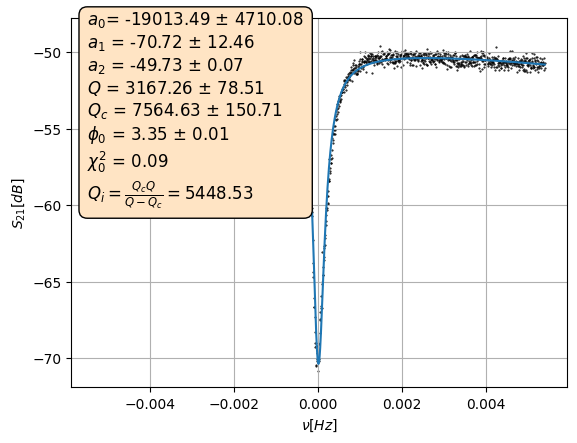

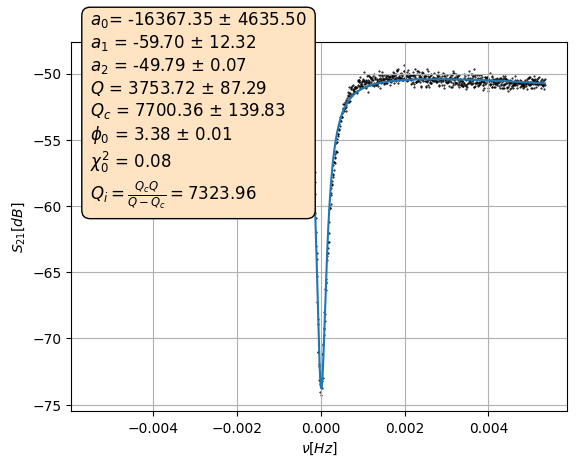

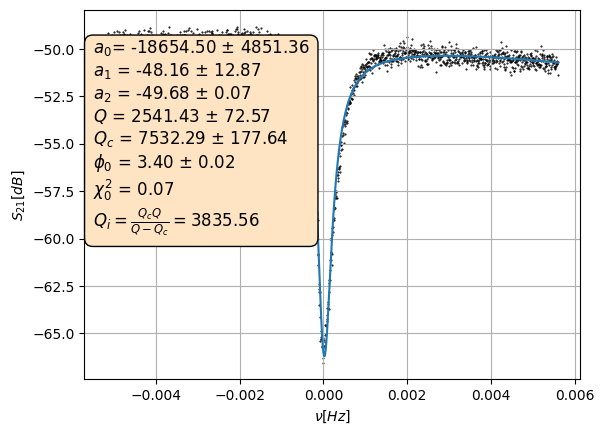

In [12]:
m,Q_i,sQ_i = [],[],[]

for i,(F,S21) in enumerate(zip(sorted_F,sorted_S21)):
    F = (F-F[np.argmin(S21)])/(F[np.argmin(S21)]) 
    lsq = LeastSquares(F,S21,1.44*np.ones_like(S21),model2)
    m.append(minuit.Minuit(lsq,*p))
    m[i].migrad()
    #if m[i].accurate is True:
    plt.plot(F,model2(F,*m[i].values), label='New_model - MIGRAD')
    plt.scatter(F,S21,color='black',marker='.',s=1, label='Data')
    plt.xlabel(r'$\nu [Hz]$')
    plt.ylabel(r'$S_{21} [dB]$')
    plt.grid()
    Q_i.append((m[i].values[3]*m[i].values[4])/(m[i].values[4] - m[i].values[3]))
    sQ_i.append(np.sqrt(m[i].errors[3]**2/m[i].values[3]**2 + m[i].errors[4]**2/m[i].values[4]**2))

    box_props = dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='bisque')
    text_box_content = (r'$a_0$= '+f'{m[i].values[0]:.2f}'+r' $\pm$ '+f'{m[i].errors[0]:.2f}\n' + 
                        r'$a_1$ = '+f'{m[i].values[1]:.2f}'+r' $\pm$ '+f'{m[i].errors[1]:.2f}\n'+
                        r'$a_2$ = '+f'{m[i].values[2]:.2f}'+r' $\pm$ '+f'{m[i].errors[2]:.2f}\n' +
                        r'$Q$ = '+f'{m[i].values[3]:.2f}'+r' $\pm$ '+f'{m[i].errors[3]:.2f}\n' +
                        r'$Q_{c}$ = '+f'{m[i].values[4]:.2f}'+r' $\pm$ '+f'{m[i].errors[4]:.2f}\n' +
                        r'$\phi_{0}$ = '+f'{m[i].values[5]:.2f}'+r' $\pm$ '+f'{m[i].errors[5]:.2f}\n'+
                        r'$\chi^{2}_{0}$ = '+ f'{(m[i].fval/m[i].ndof):.2f}\n'+
                        r'$Q_{i} = \frac{Q_{c}Q}{Q-Q_{c}} = $'+f'{(1/m[i].values[3]-1/m[i].values[4])**(-1):.2f}')
    text_box = plt.text(-0.0055, -61+0.1*i, text_box_content, fontsize=12, color='black', bbox=box_props)
    plt.show()

In [15]:
import pandas as pd
with open('Results.txt', 'w') as file:
    file.write('T\tQ\tsigma_Q\tQc\tsigma_Qc\tQi\tsigma_Qi\n')
    for i, obj in enumerate(m):
        if m[i].values[3]>0:
            T_val = int(T[i])
            Q_val = float(m[i].values[3])
            sigma_Q_val = float(m[i].errors[3])
            Qc_val = float(m[i].values[4])
            sigma_Qc_val = float(m[i].errors[4])
            Qi_val = float((1 / Q_val - 1 / Qc_val) ** (-1))
            sigma_Qi_val = float(sQ_i[i])
            
            file.write(f'{T_val}\t{Q_val}\t{sigma_Q_val}\t{Qc_val}\t{sigma_Qc_val}\t{Qi_val}\t{sigma_Qi_val}\n')

# Read the data back into a Pandas DataFrame
df = pd.read_csv('Results.txt', delimiter='\t')


C:\Users\ricca\AppData\Local\Temp\ipykernel_19636\3720449375.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [16]:
for c in df.columns:
    df[c] = df[c].astype(float)
df['1/Q'] = 1/df['Q']
df['s(1/Q)'] = (1/df['Q'])**2*df['sigma_Q']
df = df.sort_values(by=['T'])
df = df.reset_index()

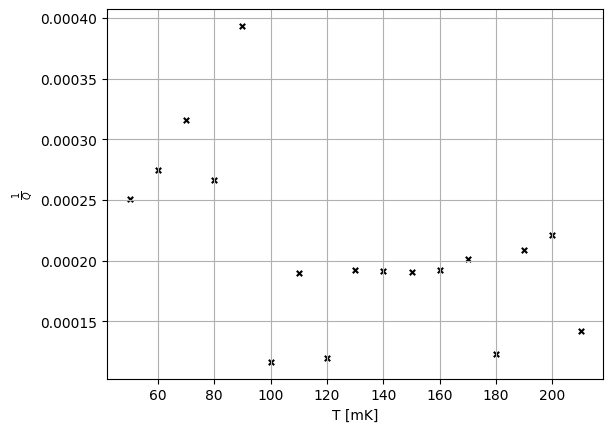

In [17]:
plt.scatter(df['T'],df['1/Q'],marker='x',s=15, color='black')
plt.ylabel(r'$\frac{1}{Q}$')
plt.xlabel('T [mK]')
plt.grid()